# 🫀🎵**Deep Networks for Anomaly detection from Heart sound**🎵🫀

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [ ]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf
import librosa
import h5py
import seaborn as sns

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score

from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, BatchNormalization, LSTM, Conv1D, MaxPooling1D
from keras import regularizers
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

## Path

In [ ]:
path = "/content/drive/MyDrive/Plaksha/Sem 4/MLPR/Dataset/the-circor-digiscope-phonocardiogram-dataset-1.0.3/hd5_files"

## Load Mel Spectograms

In [ ]:
# h5path = path + "/spectograms.h5"
h5path = path + "/mfccs_10s_butternorm_2000hz.h5"
print(h5path)

/content/drive/MyDrive/Plaksha/Sem 4/MLPR/Dataset/the-circor-digiscope-phonocardiogram-dataset-1.0.3/hd5_files/mfccs_10s_butternorm_2000hz.h5


In [ ]:
h5_filenames = []
h5_mel_specs = []
h5_outcomes = []
h5_murmurs = []

In [ ]:
with h5py.File(h5path, 'r') as file:
    for i in tqdm(file.keys()):
        h5_filenames.append(i)
        h5_mel_specs.append(file[i]['mfcc'][()])
        h5_outcomes.append(file[i]['outcome'][()])
        h5_murmurs.append(file[i]['murmur'][()].decode('utf-8'))

100%|██████████| 7170/7170 [00:07<00:00, 961.19it/s] 


In [ ]:
# check if mel specs were loaded properly
# (also check whether its shape is what you need it to be)
print("mel specs shape: ", h5_mel_specs[0].shape)

mel specs shape:  (25, 40)


### EDA (again 😆)

In [ ]:
# count number of outcomes = 1
count = 0
for outcome in h5_outcomes:
    if outcome == 1:
        count += 1
print("abnormal: ", count)
print("normal: ", len(h5_outcomes) - count)

abnormal:  3468
normal:  3702


In [ ]:
present = 0
absent = 0
unknown = 0
for murmur in h5_murmurs:
    if murmur == "Present":
        present += 1
    elif murmur == "Absent":
        absent += 1
    else:
        unknown += 1

print("present: ", present)
print("absent: ", absent)
print("unknown: ", unknown)

present:  1363
absent:  5462
unknown:  345


## Performance Metrics

In [ ]:
def outcome_weighted_accuracy(y_true, y_pred):
    # Convert predictions to binary values
    y_pred_binary = tf.round(y_pred)

    # Calculate true positives, true negatives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred_binary, 'float'))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred_binary), 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred_binary, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred_binary), 'float'))

    # Calculate the outcome weighted accuracy
    wt_acc = (5 * tp + tn) / (5 * (tp + fn) + (fp + tn))

    return wt_acc

In [ ]:
def custom_cost_metric(y_true, y_pred):
    # Convert predictions to binary values
    y_pred_binary = tf.round(y_pred)

    # Calculate true positives, true negatives, false positives, false negatives
    tp = tf.reduce_sum(tf.cast(y_true * y_pred_binary, 'float'))
    tn = tf.reduce_sum(tf.cast((1 - y_true) * (1 - y_pred_binary), 'float'))
    fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred_binary, 'float'))
    fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred_binary), 'float'))

    def c_algo(s):
        return 10 * s

    def c_exp(s, t):
        c = (25 + 397 * (s / t) - 1718 * ((s * s) / (t * t)) + 11296 * ((s * s * s * s) / (t * t * t * t)))
        return c

    def c_treat(s):
        return 10000 * s

    def c_err(s):
        return 50000 * s

    # Calculate cost components
    c_outcome_total = c_algo(tp + tn + fp + fn) + c_exp(tp + fp, tp + tn + fp + fn) + c_treat(tp) + c_err(fn)
    c_outcome = c_outcome_total / (tp + tn + fp + fn)

    return c_outcome

## Models

In [ ]:
# defining input shapes
mel_shape = h5_mel_specs[0].shape
print("mel shape: ", mel_shape)
lstm_input_shape = (mel_shape[1], mel_shape[0])
cnn_input_shape = (mel_shape[0], mel_shape[1], 1)
print("lstm input shape: ", lstm_input_shape)  # Output: (40, 25)
print("cnn input shape: ", cnn_input_shape)

n_time_intervals = mel_shape[1]

mel shape:  (25, 40)
lstm input shape:  (40, 25)
cnn input shape:  (25, 40, 1)


### CNNs

In [ ]:
def CNN_1D_model():
    model = Sequential()

    # Conv Block 1
    model.add(Conv1D(32, 5, padding='same', activation='relu', input_shape=lstm_input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))

    # Conv Block 2
    model.add(Conv1D(64, 5, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def CNN_2D_model():
    model = Sequential()

    # Conv Block 1
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=cnn_input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Conv Block 2
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))

    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    plot_model(model, to_file='CNN_2D_model_architecture.png', show_shapes=True, show_layer_names=True)

    return model

### LSTM

In [ ]:
def LSTM_model():
    model = Sequential()

    # Add LSTM layer
    model.add(LSTM(128, input_shape=lstm_input_shape))
    model.add(Dropout(0.2))

    # Add fully connected layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    plot_model(model, to_file='LSTM_model_architecture.png', show_shapes=True, show_layer_names=True)

    return model

### Plot models


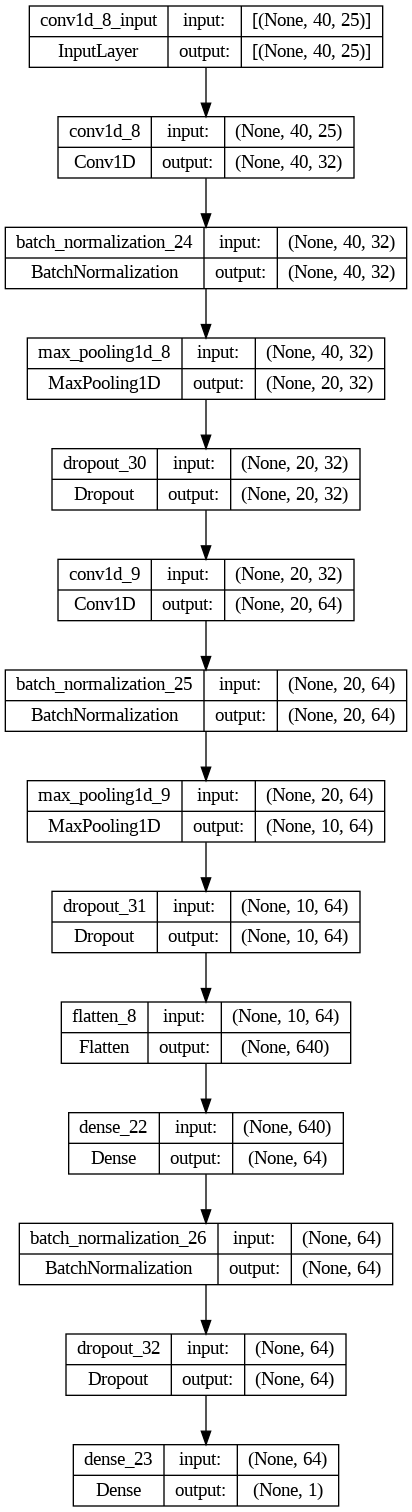

In [ ]:
plot_model(CNN_1D_model(), to_file='CNN_1D_model_architecture.png', show_shapes=True, show_layer_names=True)

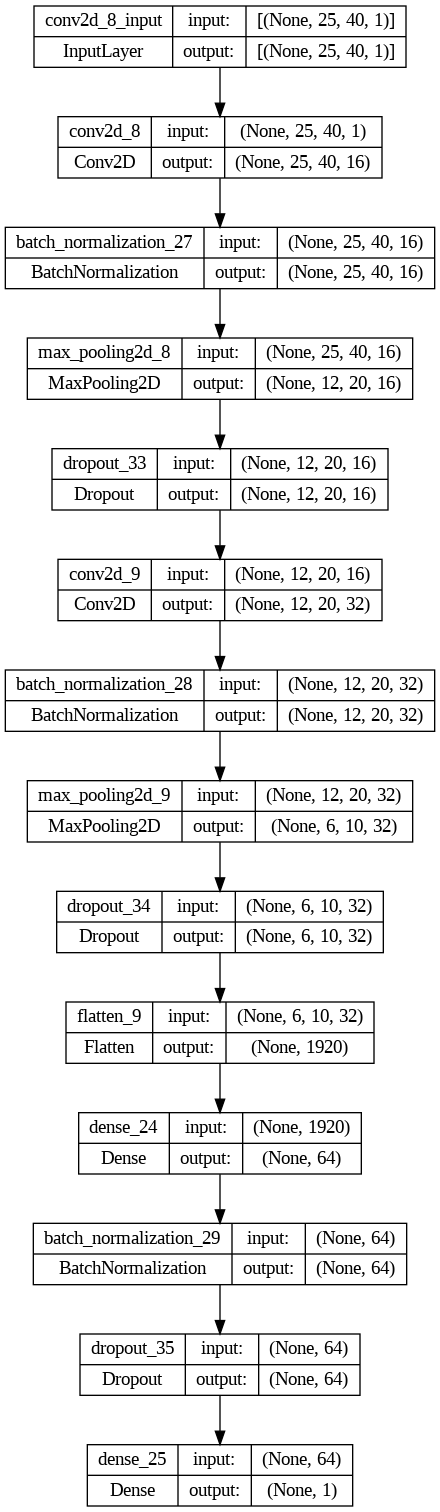

In [ ]:
plot_model(CNN_2D_model(), to_file='CNN_2D_model_architecture.png', show_shapes=True, show_layer_names=True)

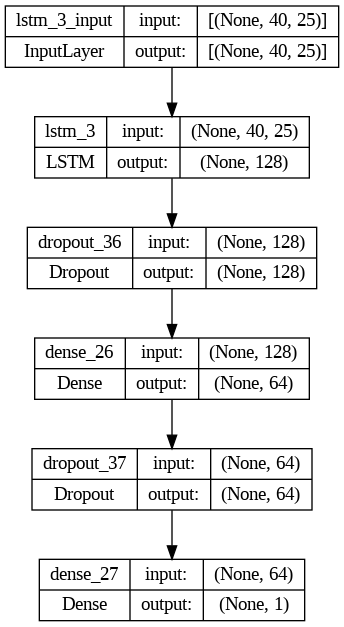

In [ ]:
plot_model(LSTM_model(), to_file='LSTM_model_architecture.png', show_shapes=True, show_layer_names=True)

### Selection

In [ ]:
# Early Stoppin
early_stopping = EarlyStopping(monitor='val_custom_cost_metric', patience=10, restore_best_weights=True)

In [ ]:
models = {
    'CNN_1D': CNN_1D_model(),
    'CNN_2D': CNN_2D_model(),
    'LSTM': LSTM_model()
}

In [ ]:
model_type = 'CNN_1D'
if model_type == 'LSTM':
    h5_mel_specs = np.array(h5_mel_specs).reshape(-1, n_time_intervals, 25)
elif model_type == 'CNN_2D':
    h5_mel_specs = np.array(h5_mel_specs).reshape(-1, 25, n_time_intervals, 1)
elif model_type == 'CNN_1D':
    h5_mel_specs = np.array(h5_mel_specs).reshape(-1, n_time_intervals, 25)
print(h5_mel_specs.shape)

(7170, 40, 25)


### Compile

In [ ]:
model = models[model_type]
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', outcome_weighted_accuracy, custom_cost_metric])

## Test Train Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(h5_mel_specs, h5_outcomes, test_size=0.15, random_state=42)
y_train = np.array(y_train)
y_test = np.array(y_test)
print("Training Datapoints: ", len(X_train))
print("Testing Datapoints: ", len(X_test))

Training Datapoints:  6094
Testing Datapoints:  1076


## **Train**

In [ ]:
epochs = 50
batch_size = 32

In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])

Epoch 1/50
191/191 [==============================] - 5s 28ms/step - loss: 0.6952 - accuracy: 0.5711 - outcome_weighted_accuracy: 0.5068 - custom_cost_metric: 14984.4121 - val_loss: 0.7072 - val_accuracy: 0.5502 - val_outcome_weighted_accuracy: 0.3603 - val_custom_cost_metric: 19692.1328
Epoch 2/50
191/191 [==============================] - 2s 10ms/step - loss: 0.6944 - accuracy: 0.5707 - outcome_weighted_accuracy: 0.4883 - custom_cost_metric: 15560.5537 - val_loss: 0.7031 - val_accuracy: 0.5437 - val_outcome_weighted_accuracy: 0.4119 - val_custom_cost_metric: 17943.9180
Epoch 3/50
191/191 [==============================] - 2s 10ms/step - loss: 0.6902 - accuracy: 0.5850 - outcome_weighted_accuracy: 0.5060 - custom_cost_metric: 15227.6475 - val_loss: 0.7115 - val_accuracy: 0.5270 - val_outcome_weighted_accuracy: 0.3055 - val_custom_cost_metric: 21162.3926
Epoch 4/50
191/191 [==============================] - 2s 10ms/step - loss: 0.6887 - accuracy: 0.5809 - outcome_weighted_accuracy: 0.5

## Results

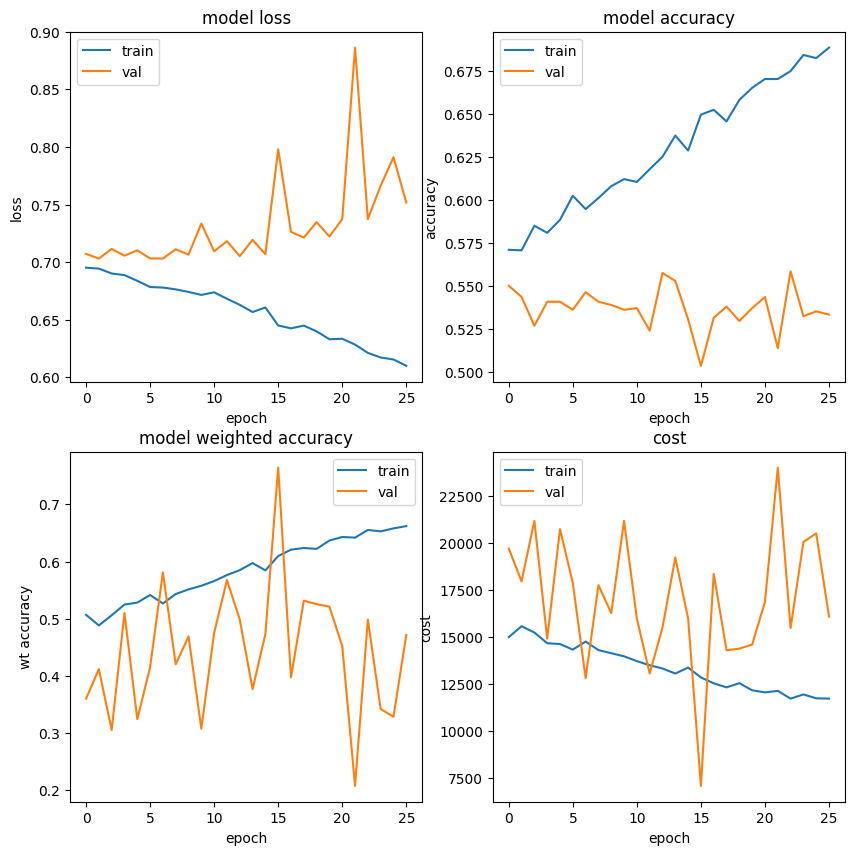

In [ ]:
# plot loss and val loss in one image, acc and val_acc in another
def plot_results():
    plt.figure(figsize=(10, 10))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])

    plt.subplot(2, 2, 3)
    plt.plot(history.history['outcome_weighted_accuracy'])
    plt.plot(history.history['val_outcome_weighted_accuracy'])
    plt.title('model weighted accuracy')
    plt.ylabel('wt accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])

    plt.subplot(2, 2, 4)
    plt.plot(history.history['custom_cost_metric'])
    plt.plot(history.history['val_custom_cost_metric'])
    plt.title('cost')
    plt.ylabel('cost')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])

plot_results()

34/34 [==============================] - 0s 3ms/step
Accuracy:  0.5037174721189591
F1 Score:  0.644
Recall:  0.9061913696060038
Weighted Accuracy:  0.7637279
Cost:  6970.73


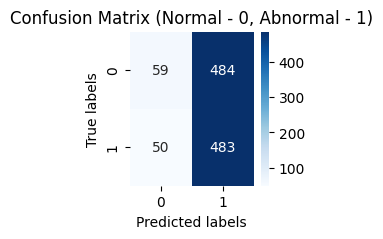

In [ ]:
y_pred = model.predict(X_test)

for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# print confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 Score: ", f1_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))
print("Weighted Accuracy: ", outcome_weighted_accuracy(y_test, y_pred).numpy())
print("Cost: ", custom_cost_metric(y_test, y_pred).numpy())

def plot_cm():
    plt.figure(figsize=(2,2))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix (Normal - 0, Abnormal - 1)')
    plt.show()
plot_cm()

## **Predicting Plaksha People's Hearts!!!** 🫀

In [ ]:
plaksha_h5path =  path +  "/mfccs_plaksha_butter_10s_2000hz.h5"

In [ ]:
plaksha_names = []
plaksha_h5_mel_specs = []
plaksha_true_outcomes = []
plaksha_pred_outcomes = []

In [ ]:
with h5py.File(plaksha_h5path, 'r') as file:
    for n, i in enumerate(file.keys()):

        if file[i]['1']['outcome'][()] == 1:
            plaksha_true_outcomes.append("Abnormal")
        else:
            plaksha_true_outcomes.append("Normal")
        plaksha_names.append(i.split(' ')[0])

        y_preds = []
        for j in file[i].keys():
            mfcc = file[i][j]['mfcc'][()]

            mfcc = np.array(mfcc).reshape(-1, 40, 25) # for LSTM and CNN1D
            # mfcc = np.array(mfcc).reshape(-1, 25, 40, 1)

            y_pred = model.predict(mfcc)
            y_preds.append(y_pred)

        out = np.mean(y_pred)
        if out <= 0.5:
            plaksha_pred_outcomes.append("Normal")
        else:
            plaksha_pred_outcomes.append("Abnormal")

print(plaksha_pred_outcomes)

1/1 [==============================] - 0s 24ms/step
['Normal', 'Normal', 'Normal', 'Normal', 'Abnormal', 'Normal', 'Abnormal', 'Abnormal', 'Normal', 'Abnormal', 'Abnormal', 'Abnormal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Normal', 'Abnormal', 'Normal', 'Abnormal', 'Abnormal', 'Normal', 'Abnormal', 'Abnormal', 'Abnormal', 'Normal', 'Normal']


In [ ]:
plaksha_df = pd.DataFrame({
    'Name': plaksha_names,
    'true_outcomes': plaksha_true_outcomes,
    'predicted_outcomes': plaksha_pred_outcomes
})
plaksha_df

,Name,true_outcomes,predicted_outcomes
0,Abhigyaan,Normal,Normal
1,Abhivarya,Normal,Normal
2,Aman,Normal,Normal
3,Angad,Normal,Normal
4,LittleAbnormal,Abnormal,Abnormal
5,Male,Normal,Normal
6,Male,Normal,Abnormal
7,Muku,Normal,Abnormal
8,Parth,Normal,Normal
9,Ranga,Normal,Abnormal


Took help from - https://github.com/seth814/Audio-Classification